<a href="https://colab.research.google.com/github/Aswani-ReddyKV/Capstone_Sentiment_Recommendation/blob/main/Aswani_Reddy_Sentiment_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# install required packages
# !pip install -q openai langchain chromadb faiss-cpu PyPDF tiktoken docarray langchain-openai langchain-community

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

import pickle
import os

import xgboost as xgb
from numpy import *

In [3]:
%matplotlib inline

In [4]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import string
from wordcloud import WordCloud

from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [5]:
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 2)

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
# Define the path where all files are present on google drive
folder_path = '/content/drive/MyDrive/Colab Notebooks/Course_6_GenAI/Sentiment_Analysis/'

# **Loading Dataset**



In [8]:
# importing dataset
df_reviews = pd.read_csv(folder_path+"sample30.csv")
df_reviews.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [9]:
metadata = pd.read_csv(folder_path+"Data+Attribute+Description.csv",  encoding='latin1')
metadata

,Attribute,Attribute Description
0,id,Uniques identity number to identify each unique review given by the user to a particular product in the dataset
1,brand,Name of the brand of the product to which user has given review and rating
2,categories,"Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more."
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added review or rating
5,reviews_date,Date on which the review has been added by the user
6,reviews_didPurchase,Whether a particular user has purchased the product or not
7,reviews_doRecommend,Whether a particular user has recommended the product or not
8,reviews_rating,Rating given by the user to a particular product
9,reviews_text,Review given by the user to a particular product


# **Exploratory Data Analysis**



In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

###Get the unique value count for each column###

In [11]:
df_reviews.nunique()

,0
id,271
brand,214
categories,270
manufacturer,227
name,271
reviews_date,6857
reviews_didPurchase,2
reviews_doRecommend,2
reviews_rating,5
reviews_text,27282


In [12]:
# Calculates the percentage of missing values in each column of a DataFrame.
# Args:
#   X (pandas.DataFrame): The input DataFrame.
# Returns:
#   pandas.DataFrame: A DataFrame containing the percentage of missing values for each column, sorted in descending order.
def get_missing_value_percentage(X):
  percent_missing = round((X.isnull().sum() / X.isnull().count()*100),3).to_frame('missing_percentage').sort_values('missing_percentage',ascending = False)
  return percent_missing

In [13]:
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_userProvince,9.94e+01
reviews_userCity,9.36e+01
reviews_didPurchase,4.69e+01
reviews_doRecommend,8.57e+00
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
brand,0.00e+00


#### ***Observatoins*** ####

Here are the key takeways from the above results:
* Thare are 30000 rows
* Total of 271 unique products
* Total Categories - 270
* Thare are 24914 users
* Three fields are there in the dataset which are having more than 40% of missing values(reviews_userProvince, reviews_userCity, reviews_didPurchase)

####Drop the columns with more than 40% of missing values####

In [14]:
df_reviews.drop(columns=["reviews_userProvince", "reviews_userCity", "reviews_didPurchase"],inplace=True)
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_doRecommend,8.57e+00
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
brand,0.00e+00
categories,0.00e+00
name,0.00e+00


In [15]:
round(df_reviews[["reviews_doRecommend"]].value_counts(normalize=True) * 100, 2)

,proportion
reviews_doRecommend,
True,94.35
False,5.65


Dropping "reviews_doRecommend" column as around 94% of values are True and rest of them are False. By having this column we will get skewed results. So lets drop this column.

In [16]:
df_reviews = df_reviews.drop(columns=['reviews_doRecommend'])
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
brand,0.00e+00
categories,0.00e+00
name,0.00e+00
reviews_rating,0.00e+00


In [17]:
df_reviews['reviews_title'].fillna('unknown',inplace=True)
df_reviews['reviews_username'].fillna('unknown',inplace=True)
df_reviews['manufacturer'].fillna('Others',inplace=True)
get_missing_value_percentage(df_reviews)

,missing_percentage
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
categories,0.00e+00
brand,0.00e+00
name,0.00e+00
manufacturer,0.00e+00
reviews_rating,0.00e+00
reviews_text,0.00e+00
reviews_title,0.00e+00


In [18]:
df_reviews = df_reviews[~ df_reviews['reviews_date'].isna()]
get_missing_value_percentage(df_reviews)

,missing_percentage
user_sentiment,3.00e-03
brand,0.00e+00
id,0.00e+00
categories,0.00e+00
manufacturer,0.00e+00
reviews_date,0.00e+00
name,0.00e+00
reviews_rating,0.00e+00
reviews_text,0.00e+00
reviews_title,0.00e+00


In [19]:
round(df_reviews[["user_sentiment"]].value_counts(normalize=True) * 100, 2)

,proportion
user_sentiment,
Positive,88.79
Negative,11.21


In [20]:
df_reviews['user_sentiment'].fillna('Positive', inplace=True)
get_missing_value_percentage(df_reviews)

,missing_percentage
id,0.0
brand,0.0
categories,0.0
manufacturer,0.0
name,0.0
reviews_date,0.0
reviews_rating,0.0
reviews_text,0.0
reviews_title,0.0
reviews_username,0.0


In [21]:
# mapping positive to 1 and negative to 0
df_reviews['user_sentiment']=df_reviews['user_sentiment'].map({'Positive':1,'Negative':0})

In [22]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29954 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29954 non-null  object
 1   brand             29954 non-null  object
 2   categories        29954 non-null  object
 3   manufacturer      29954 non-null  object
 4   name              29954 non-null  object
 5   reviews_date      29954 non-null  object
 6   reviews_rating    29954 non-null  int64 
 7   reviews_text      29954 non-null  object
 8   reviews_title     29954 non-null  object
 9   reviews_username  29954 non-null  object
 10  user_sentiment    29954 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 2.7+ MB


In [23]:
df_reviews.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was ...",Disappointed,rebecca,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0


Text(0.5, 1.0, 'Frequency distribution of reviews_rating')

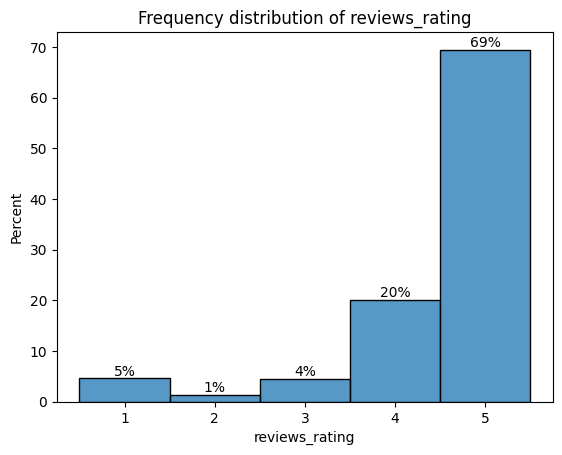

In [24]:
# Frequency plot of reviews_rating column
ax=sns.histplot(df_reviews['reviews_rating'],stat='percent',discrete='bool')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
plt.title("Frequency distribution of reviews_rating")

<Axes: xlabel='user_sentiment', ylabel='count'>

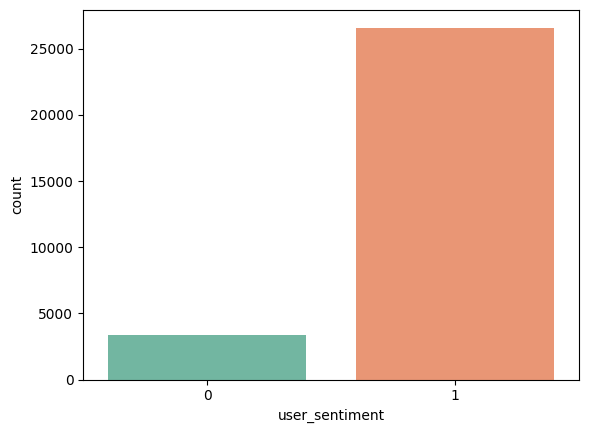

In [25]:

sns.countplot(x='user_sentiment', data= df_reviews, palette="Set2")

<Axes: xlabel='brand'>

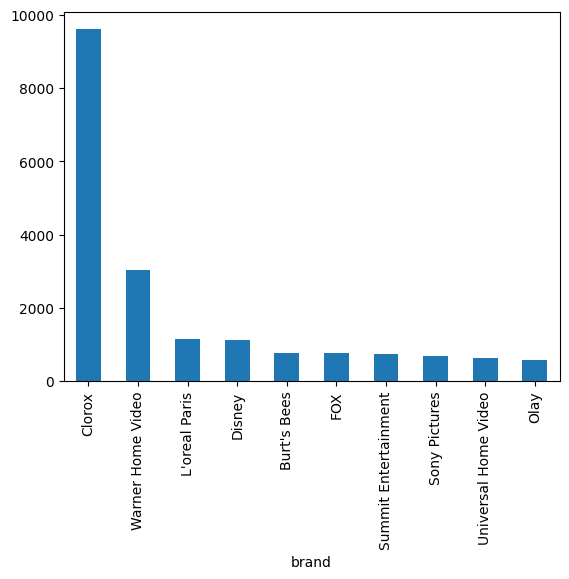

In [26]:
# Filter the top 10 brands among the positive sentiments
df_reviews[df_reviews['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar')

<Axes: xlabel='brand'>

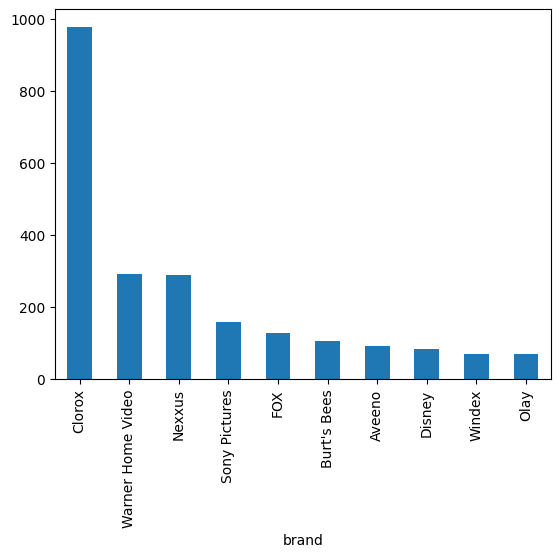

In [27]:
# Filter the top 10 brands among the negative sentiments
df_reviews[df_reviews['user_sentiment']==0].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar')

In [28]:
get_missing_value_percentage(df_reviews)

,missing_percentage
id,0.0
brand,0.0
categories,0.0
manufacturer,0.0
name,0.0
reviews_date,0.0
reviews_rating,0.0
reviews_text,0.0
reviews_title,0.0
reviews_username,0.0


In [29]:
df_reviews["reviews_full_text"] = df_reviews[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

# **Task#2 Text Processing**

In [30]:
'''function to clean the text and remove all the unnecessary elements.'''
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub("\[\s*\w*\s*\]", "", text)
    dictionary = "abc".maketrans('', '', string.punctuation)
    text = text.translate(dictionary)
    text = re.sub("\S*\d\S*", "", text)

    return text

In [31]:
df_clean = df_reviews[['id','name', 'reviews_full_text', 'user_sentiment']]

In [32]:
df_clean["reviews_text"] = df_clean.reviews_full_text.apply(lambda x: clean_text(x))

In [33]:
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [34]:
stop_words = set(stopwords.words('english'))

In [35]:
def remove_stopword(text):
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

In [36]:
lemmatizer = WordNetLemmatizer()
# Lemmatize the sentence
def lemma_text(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopword(text))) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(words)

In [37]:
df_clean["reviews_text_cleaned"] = df_clean.reviews_text.apply(lambda x: lemma_text(x))

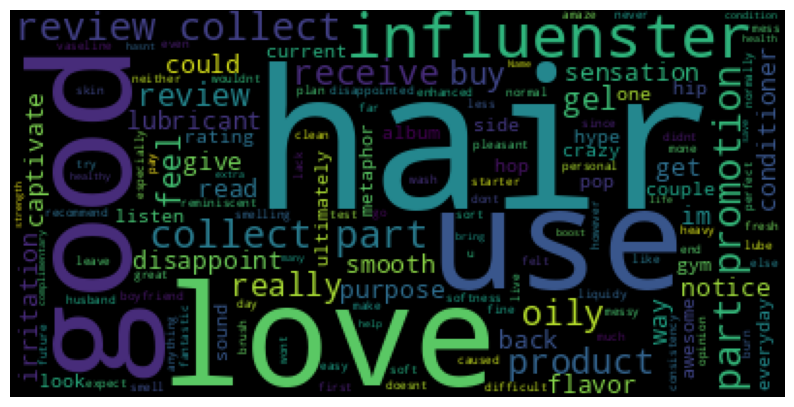

In [38]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(stopwords=stop_words,max_words=200).generate(str(df_clean.reviews_text_cleaned))

print(wordcloud)
plt.figure(figsize= (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

(array([1.1435e+04, 1.1719e+04, 3.8070e+03, 1.4660e+03, 6.9300e+02,
        3.1200e+02, 2.0800e+02, 1.0900e+02, 6.1000e+01, 3.9000e+01,
        3.3000e+01, 3.0000e+01, 6.0000e+00, 6.0000e+00, 6.0000e+00,
        5.0000e+00, 3.0000e+00, 2.0000e+00, 4.0000e+00, 2.0000e+00,
        5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   4.  ,   79.44,  154.88,  230.32,  305.76,  381.2 ,  456.64,
         532.08,  607.52,  682.96,  758.4 ,  833.84,  909.28,  984.72,
        1060.16, 1135.6 , 1211.04, 1286.48, 1361.92, 1437.36, 1512.8 ,
        1588.24, 1663.68, 1739.12, 1814.56, 1890.  , 1965.44, 2040.88,
        2116.32, 2191.76, 2267.2 ,

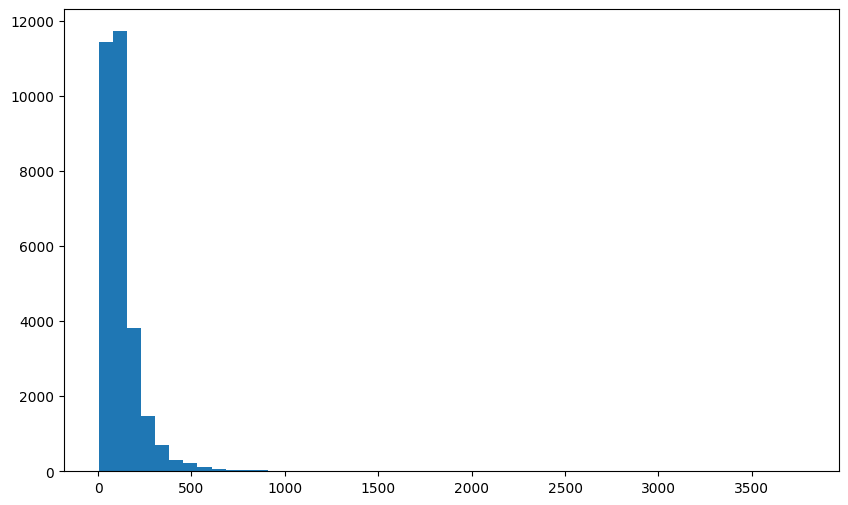

In [39]:
#visualise the data according to the 'Review Text' character length
plt.figure(figsize=(10,6))
reviews_lens = [len(d) for d in df_clean.reviews_text_cleaned]
plt.hist(reviews_lens, bins = 50)

In [40]:
def getMostCommonWords(reviews, n_most_common):
    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

In [41]:
pos_reviews = df_clean[df_clean['user_sentiment']==1]
getMostCommonWords(pos_reviews['reviews_text_cleaned'],10)

[('great', 14494),
 ('love', 12433),
 ('use', 11982),
 ('product', 11395),
 ('movie', 10021),
 ('review', 8576),
 ('part', 8349),
 ('clean', 7982),
 ('promotion', 7946),
 ('wipe', 7619)]

In [42]:
neg_reviews = df_clean[df_clean['user_sentiment']==0]
getMostCommonWords(neg_reviews['reviews_text_cleaned'],10)

[('use', 1560),
 ('product', 1353),
 ('review', 900),
 ('part', 844),
 ('movie', 828),
 ('promotion', 802),
 ('collect', 750),
 ('wipe', 713),
 ('like', 710),
 ('love', 568)]

In [43]:
#function to collect the n-gram frequency of words
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [44]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(pos_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 2]]


,0,1
0,review collect,7520
1,collect promotion,7520
2,clorox wipe,2578
3,great product,1902
4,great movie,1701
5,easy use,1548
6,love clorox,1174
7,love product,1126
8,good movie,980
9,use clorox,949


In [45]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(neg_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 2]]


,0,1
0,review collect,748
1,collect promotion,748
2,clorox wipe,259
3,use product,177
4,old formula,172
5,new formula,163
6,use clorox,152
7,bring old,116
8,great product,111
9,resident evil,102


--1 [[1 1 1 ... 1 1 2]]


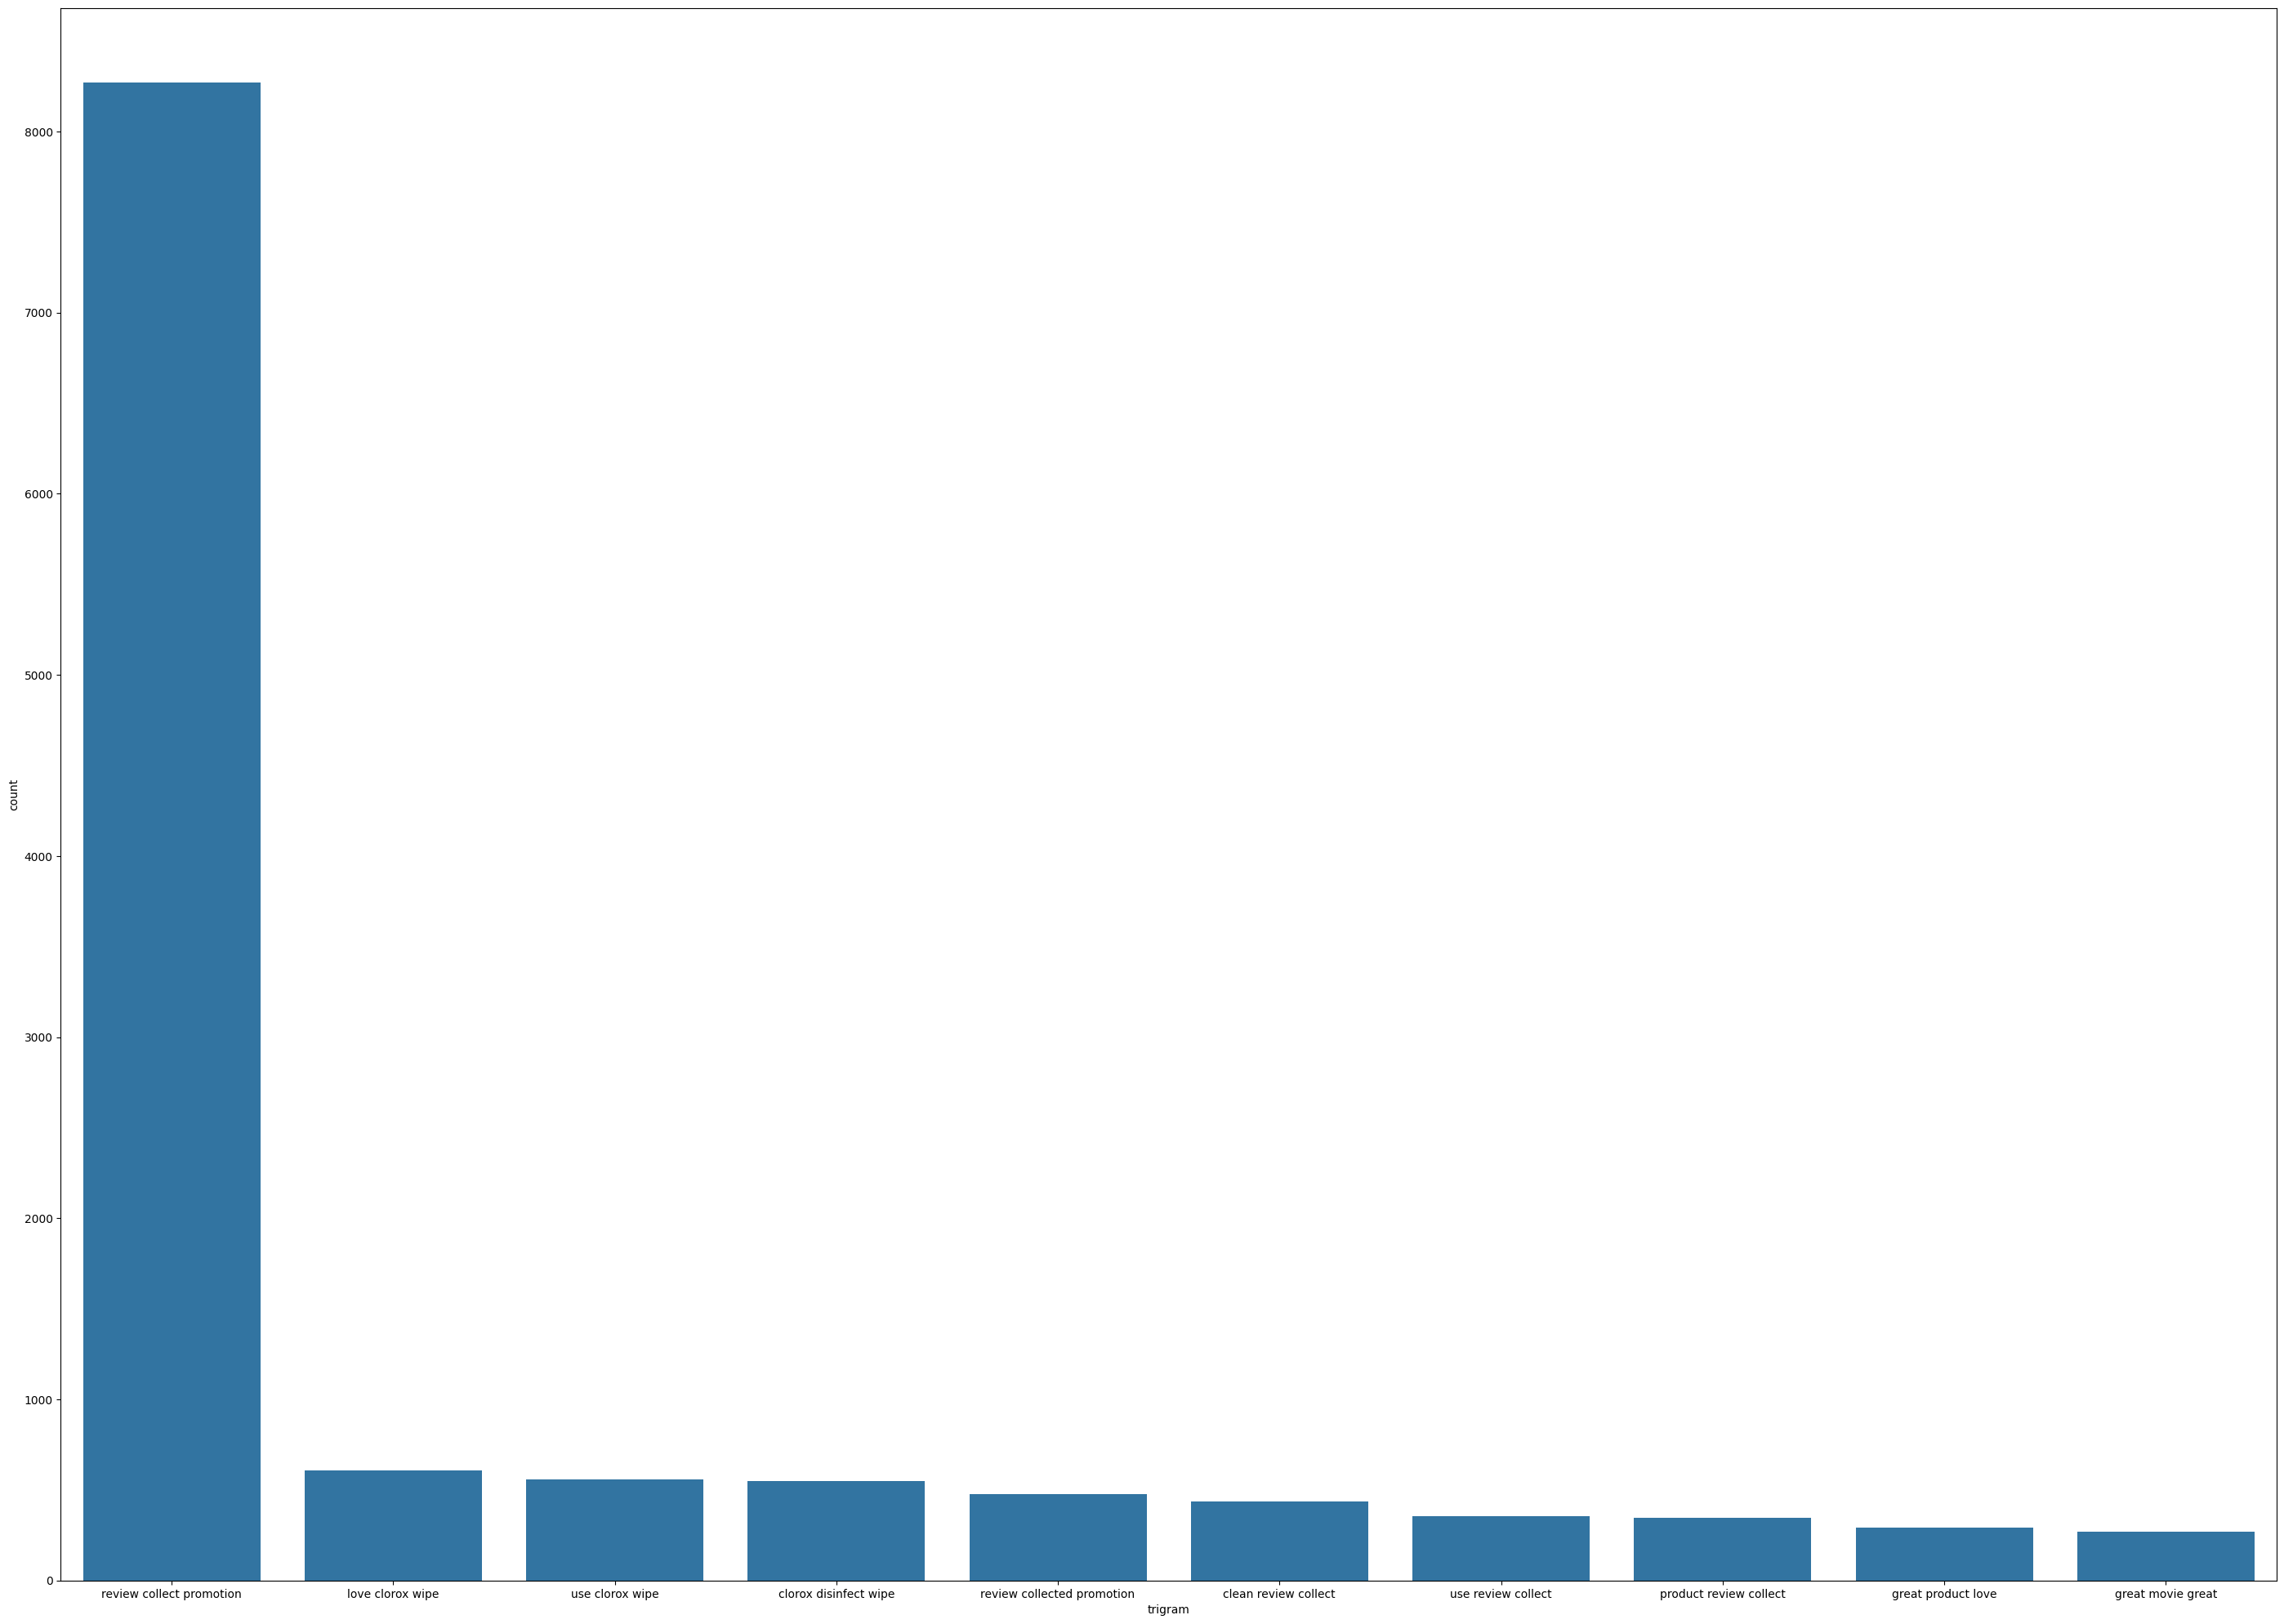

In [46]:
#logic to find the top 10 trigram frequency among the reviews_text in the cleaned datafram(df_clean).
common_words = get_top_n_ngram(df_clean.reviews_text_cleaned, 3, 10)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[35,25])
fig = sns.barplot(x=df3['trigram'], y=df3['count'])

In [47]:
X = df_clean['reviews_text_cleaned']
y = df_clean['user_sentiment']

# **Task#3 Feature Extraction**

In [48]:
no_of_classes= len(pd.Series(y).value_counts())

In [49]:
#Distribution of the target variable data in terms of proportions.
for i in range(0,no_of_classes):
    print("Percent of {0}s: ".format(i), round(100*pd.Series(y).value_counts()[i]/pd.Series(y).value_counts().sum(),2), "%")

Percent of 0s:  11.21 %
Percent of 1s:  88.79 %


In [50]:
#using TF-IDF vectorizer using the parameters to get 650 features.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True,
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_clean['reviews_text_cleaned'])

y= df_clean['user_sentiment']

In [51]:
print(tfidf_vectorizer.get_feature_names_out())

['able' 'absolutely' 'absolutely love' 'act' 'action' 'action movie'
 'actor' 'actually' 'add' 'age' 'ago' 'amaze' 'amazing' 'apply' 'area'
 'ask' 'available' 'away' 'awesome' 'awesome movie' 'awesome product'
 'awful' 'baby' 'bad' 'bag' 'bathroom' 'bathroom kitchen' 'beautiful'
 'bee' 'begin' 'believe' 'best' 'best buy' 'best product' 'big' 'bit'
 'black' 'bleach' 'blu' 'blu ray' 'bluray' 'body' 'bottle' 'box' 'boy'
 'brand' 'break' 'bring' 'bring cocoa' 'bring old' 'brown' 'burt'
 'burt bee' 'buy' 'canister' 'car' 'care' 'carpet' 'carry' 'cast' 'cd'
 'chair' 'change' 'character' 'cheap' 'child' 'chip' 'classic' 'classroom'
 'clay' 'clean' 'clean bathroom' 'clean disinfect' 'clean easy'
 'clean fresh' 'clean great' 'clean kitchen' 'clean love' 'clean mess'
 'clean product' 'clean review' 'clean smell' 'clean ups' 'clean use'
 'clean wipe' 'cleaner' 'cleaning' 'cleanup' 'clear' 'clorox'
 'clorox disinfect' 'clorox love' 'clorox product' 'clorox wipe' 'close'
 'cocoa' 'cold' 'collect' '

In [52]:
# splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=42, test_size=0.25)

### Class imbalance (using SMOTE) ###

In [53]:
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 19965, 0: 2500})
After Counter({1: 19965, 0: 19965})


# **Task#4 Model Buildling**

In [54]:
class ModelBuilder:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test


    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)

    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*30)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*"*30)
        print("\n")

        self.classification_report(y_pred_class)
        print("*"*30)
        print("\n")
        self.confusion_matrix(y_pred_class)

        print("*"*30)
        print("\n")

        metrics.RocCurveDisplay.from_estimator(self.model, self.x_test, self.y_test)

        return self.result_metrics

    def evaluate_metrics(self, y_pred_class):
        result_metrics = []
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)

        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")

        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics

    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])


    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", fmt=".2%")

        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()

    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))

### Logistic Regression ###

In [55]:
# Build the Logistic Regression model.
%time

logreg_ci = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")
lr_ci_modebuilder = ModelBuilder(logreg_ci, X_train, X_test, y_train, y_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [56]:
# Train and Predict the Test Labels
y_pred_class  = lr_ci_modebuilder.train_model()



******************************
Accuracy is : 85.7%
Precision is : 95.4%
Recall is : 88.1%
F1 Score is : 91.6%
Roc-Auc Score is:88.5%
******************************


              precision    recall  f1-score   support

           0       0.42      0.67      0.52       858
           1       0.95      0.88      0.92      6631

    accuracy                           0.86      7489
   macro avg       0.69      0.78      0.72      7489
weighted avg       0.89      0.86      0.87      7489

******************************




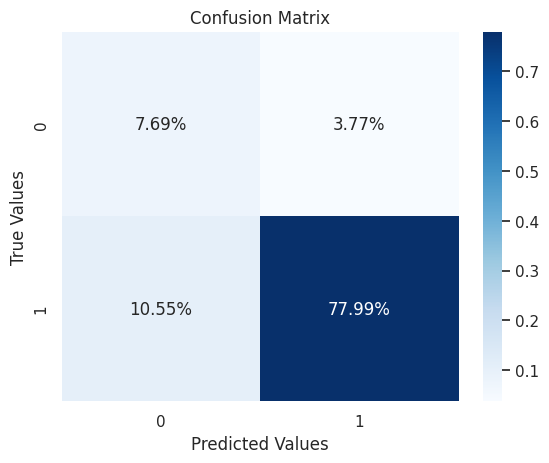

******************************




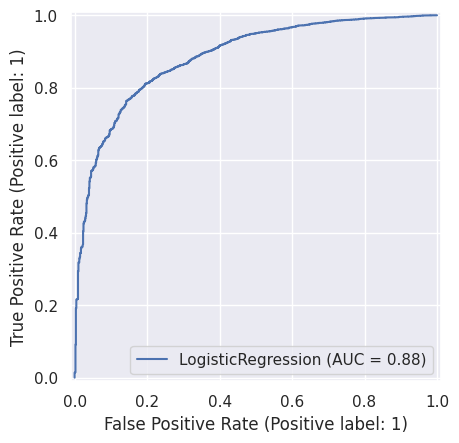

In [57]:
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)

### Naive Bayes ###

In [58]:
mnb = MultinomialNB(alpha=1.0)
mnb_modebuilder = ModelBuilder(mnb, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 79.3%
Precision is : 95.4%
Recall is : 80.4%
F1 Score is : 87.3%
Roc-Auc Score is:83.0%
******************************


              precision    recall  f1-score   support

           0       0.32      0.70      0.44       858
           1       0.95      0.80      0.87      6631

    accuracy                           0.79      7489
   macro avg       0.64      0.75      0.66      7489
weighted avg       0.88      0.79      0.82      7489

******************************




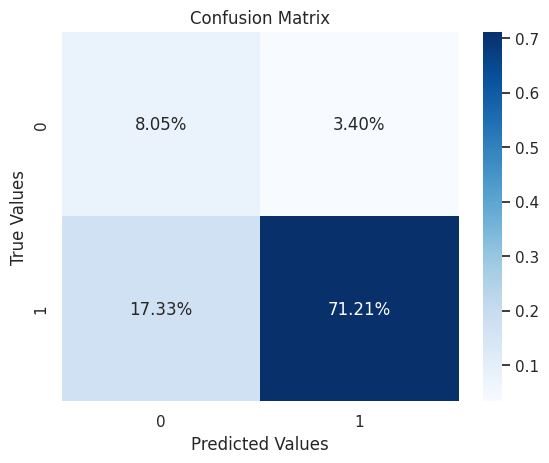

******************************




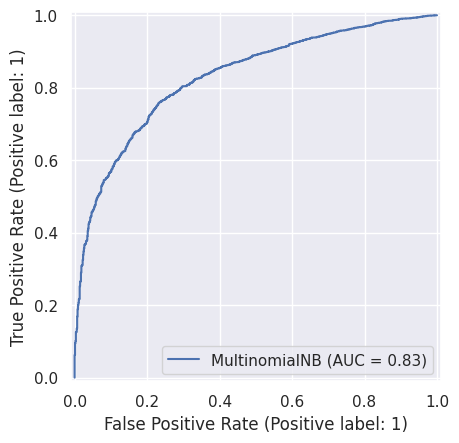

In [59]:
# Train and Predict the Test Labels
y_pred_class  = mnb_modebuilder.train_model()
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)

### Decision Tree ###

In [60]:
dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)

In [61]:
dt_modelbuilder = ModelBuilder(dt, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 79.1%
Precision is : 93.9%
Recall is : 81.7%
F1 Score is : 87.4%
Roc-Auc Score is:76.5%
******************************


              precision    recall  f1-score   support

           0       0.29      0.59      0.39       858
           1       0.94      0.82      0.87      6631

    accuracy                           0.79      7489
   macro avg       0.62      0.70      0.63      7489
weighted avg       0.87      0.79      0.82      7489

******************************




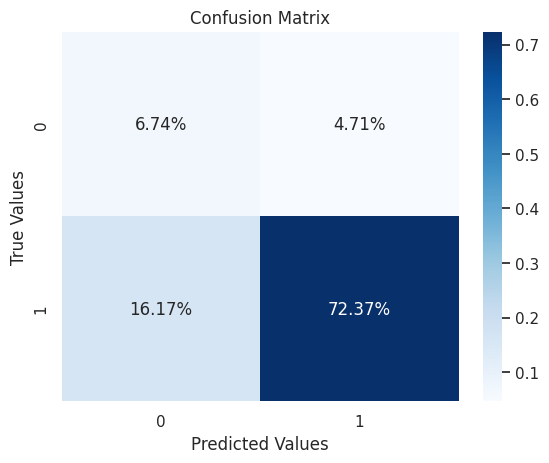

******************************




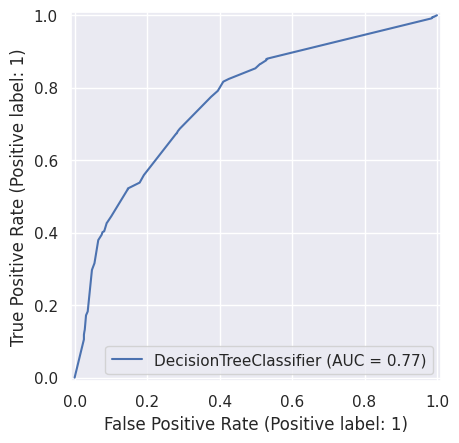

In [62]:
y_pred_class  = dt_modelbuilder.train_model()
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)

### Random Forrest ###

In [63]:
rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")

In [64]:
params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50, 100]
}

In [65]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")

In [66]:
%time
grid_search.fit(X_train, y_train)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs
Fitting 4 folds for each of 64 candidates, totalling 256 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='f1', verbose=1)

In [67]:
rf_best = grid_search.best_estimator_
rf_modebuilder = ModelBuilder(rf_best, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 79.6%
Precision is : 94.4%
Recall is : 81.7%
F1 Score is : 87.6%
Roc-Auc Score is:81.9%
******************************


              precision    recall  f1-score   support

           0       0.31      0.63      0.41       858
           1       0.94      0.82      0.88      6631

    accuracy                           0.80      7489
   macro avg       0.63      0.72      0.64      7489
weighted avg       0.87      0.80      0.82      7489

******************************




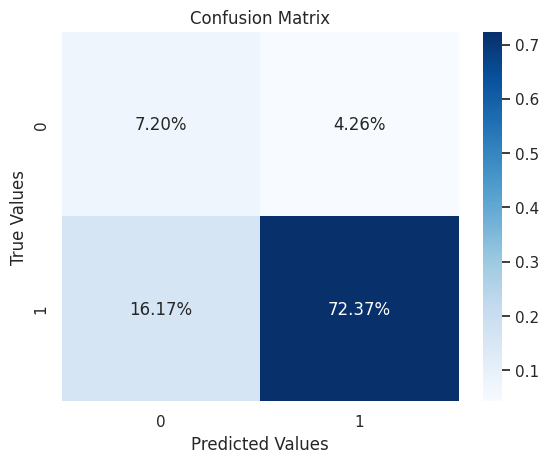

******************************




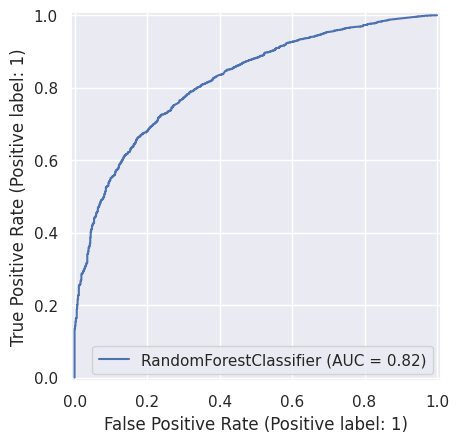

In [68]:
# Train and Predict the Test Labels
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

### XGBoost Classifier ###

In [69]:
xgclf = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42) #based on the tuned parameters
xg_modebuilder = ModelBuilder(xgclf, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 88.0%
Precision is : 94.6%
Recall is : 91.6%
F1 Score is : 93.1%
Roc-Auc Score is:88.3%
******************************


              precision    recall  f1-score   support

           0       0.48      0.60      0.53       858
           1       0.95      0.92      0.93      6631

    accuracy                           0.88      7489
   macro avg       0.71      0.76      0.73      7489
weighted avg       0.89      0.88      0.89      7489

******************************




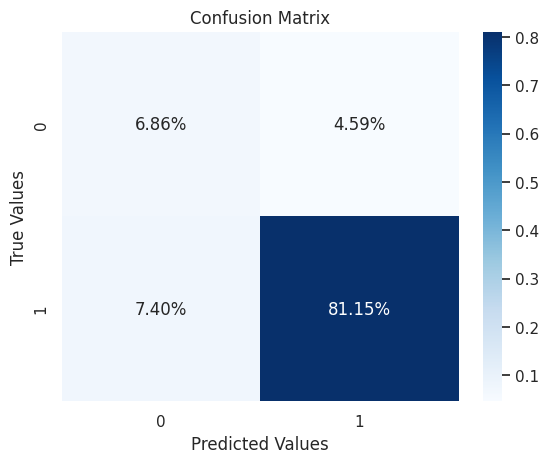

******************************




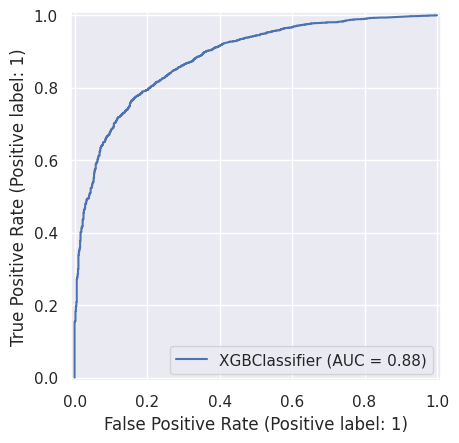

In [70]:
# Train and Predict the Test Labels
y_pred_class  = xg_modebuilder.train_model()
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)

In [71]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','Auc Score'],
        'Logistic Regression': lr_metrics,
        'Naive Bayes': nb_metrics,
        'Decision Tree': dt_metrics_cv,
         'Random Forrest': rf_metrics,
        'XG Boost': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Decision Tree','Random Forrest',
                                                    'XG Boost'] )

df_metrics

,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forrest,XG Boost
0,Accuracy,0.86,0.79,0.79,0.80,0.88
1,Precision,0.95,0.95,0.94,0.94,0.95
2,Recall,0.88,0.80,0.82,0.82,0.92
3,F1Score,0.92,0.87,0.87,0.88,0.93
4,Auc Score,0.88,0.83,0.77,0.82,0.88


In [72]:
def save_object(obj, filename):
    # Create the 'pickle' directory if it doesn't exist
    os.makedirs("pickle", exist_ok=True)
    filename = "pickle/"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [73]:
save_object(xgclf, 'sentiment-classification-xg-boost-model')

In [74]:
save_object(tfidf_vectorizer, 'tfidf-vectorizer')

In [75]:
save_object(df_clean, 'cleaned-data')


# **Task#5 Recommendation System**

We need to build the below two recommendation system

User-based recommendation system\
Item-based recommendation system

In [76]:
df_reviews[(df_reviews["reviews_title"] == "unknown") | (df_reviews["reviews_username"] == "unknown")].shape

(247, 12)

In [77]:
user_recommendation_df_columns = ['id', 'name', 'reviews_rating', 'reviews_username']
user_recommendation_df = df_reviews[user_recommendation_df_columns]
user_recommendation_df.head()

,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557


In [78]:
train, test = train_test_split(user_recommendation_df, test_size=0.30, random_state=42)

In [79]:
print(train.shape)
print(test.shape)

(20967, 4)
(8987, 4)


In [80]:
user_recommendation_df_pivot = train.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)
user_recommendation_df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf8AoBilAPnD_xkzJ2,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCi

In [81]:
# Copy the train dataset into dummy_train
recommendation_user_dummy_train = train.copy()

In [82]:
# The products not rated by user is marked as 1 for prediction.
recommendation_user_dummy_train['reviews_rating'] = recommendation_user_dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [83]:
# Convert the dummy train dataset into matrix format
recommendation_user_dummy_train = recommendation_user_dummy_train.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(1)
recommendation_user_dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf8AoBilAPnD_xkzJ2,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCi

In [84]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"
user_input = "manny"

Cosine Similarity Cosine Similarity measures how similar two vectors are by calculating the cosine of the angle between them. In our case, we'll use it to compare the reviews_rating columns of different products.

Adjusted Cosine Similarity Adjusted Cosine Similarity is a refined version of Cosine Similarity that accounts for user-specific rating biases. Some users tend to rate items higher or lower than others, regardless of the actual quality. To address this, we adjust each user's ratings by subtracting their average rating from each individual rating. This helps to normalize ratings across users, leading to more accurate similarity comparisons.

### User Based Recommendation System ###

In [85]:
# Create Pivot the train ratings data into matrix
# In this case columns are Products and the rows are usernames.
user_recommendation_df_pivot = train.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
user_recommendation_df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf8AoBilAPnD_xkzJ2,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCi

In [86]:
mean = np.nanmean(user_recommendation_df_pivot, axis=1)
user_recommendation_df_subtracted = (user_recommendation_df_pivot.T-mean).T
user_recommendation_df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf8AoBilAPnD_xkzJ2,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCi

In [87]:


# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(user_recommendation_df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### User-User Prediction ###
We will predict ratings for a user by considering only those users who have a positive correlation with the target user. Users with negative correlations are excluded as they are less similar to the target user. By focusing on positively correlated users, we can make more accurate predictions based on similar preferences

In [88]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [89]:
user_predicted_ratings = np.dot(user_correlation, user_recommendation_df_pivot.fillna(0))
print(user_predicted_ratings.shape)
user_predicted_ratings

(18240, 250)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [90]:
user_final_rating = np.multiply(user_predicted_ratings,recommendation_user_dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf8AoBilAPnD_xkzJ2,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCi

In [91]:
save_object(user_final_rating, "user_final_rating")

*** Task#6 Recommendation of Top 20 products ***

In [92]:
recommendations_user_user = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations_user_user

,manny
id,
AVpfPaoqLJeJML435Xk9,55.32
AVpfRTh1ilAPnD_xYic2,29.34
AVpe59io1cnluZ0-ZgDU,22.17
AVpe41TqilAPnD_xQH3d,18.33
AVpf3VOfilAPnD_xjpun,12.02
AVpfM_ytilAPnD_xXIJb,11.16
AVpfJP1C1cnluZ0-e3Xy,8.86
AVpf2tw1ilAPnD_xjflC,8.48
AVpfR5m0LJeJML436K3W,7.28


In [93]:
#display the top 20 product id, name and similarity_score
final_recommendations_user = pd.DataFrame({'product_id': recommendations_user_user.index, 'similarity_score' : recommendations_user_user})
final_recommendations_user.reset_index(drop=True)
pd.merge(final_recommendations_user, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,55.32
2319,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),29.34
3110,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),22.17
3563,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),18.33
4100,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,12.02
10018,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,11.16
10204,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,8.86
11646,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),8.48
12132,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,7.28
12274,AVpe9W4D1cnluZ0-avf0,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,6.91


In [94]:
def get_top_recommendation_users(users):
    new_df = pd.DataFrame()
    for user_input in users:
        try:
            temp_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
            temp = temp_recommendations.to_frame().reset_index()
            temp = temp[temp.columns.difference(['id'])].T
            temp.columns = [f"product{ind}" for ind in range(len(temp.columns))]
            temp.insert(0, "user", user_input)

            if len(new_df) != 0:
                new_df = pd.concat([new_df, temp], ignore_index=True, axis=0)
            else:
                new_df = temp

        except:
            continue

    return new_df

In [95]:
temp_user_recommendation_df = get_top_recommendation_users(train.reviews_username.unique())

In [96]:
save_object(temp_user_recommendation_df.sort_values(by=["product0"], ascending=False).head(10), "best_recommendation_users")

In [97]:
temp_user_recommendation_df.sort_values(by=["product0"], ascending=False).head(10)

,user,product0,product1,product2,product3,product4,product5,product6,product7,product8,product9,product10,product11,product12,product13,product14,product15,product16,product17,product18,product19
7353,cdavadi,78.36,27.21,20.07,13.36,11.00,10.62,8.15,5.99,5.95,5.80,4.90,4.37,4.25,3.90,3.59,3.59,3.45,3.32,3.02,2.85
9965,walt,78.36,27.21,20.07,13.36,11.00,10.62,8.15,5.99,5.95,5.80,4.90,4.37,4.25,3.90,3.59,3.59,3.45,3.32,3.02,2.85
9831,scb91,78.36,27.21,20.07,13.36,11.00,10.62,8.15,5.99,5.95,5.80,4.90,4.37,4.25,3.90,3.59,3.59,3.45,3.32,3.02,2.85
335,mudcat75979,73.89,32.14,16.48,10.36,8.85,8.45,5.78,5.45,4.94,4.82,4.61,4.14,3.82,3.57,3.37,3.37,3.31,2.89,2.89,2.83
1686,sean,70.24,27.31,18.74,14.08,10.14,8.68,7.27,5.37,4.99,4.41,3.99,3.67,3.59,3.09,2.92,2.92,2.75,2.50,2.50,2.50
3220,brian,65.46,15.81,13.04,10.38,8.96,7.42,6.67,6.23,5.17,4.94,4.79,4.77,4.27,4.23,4.22,4.21,4.16,4.12,4.07,3.67
2334,robert,63.94,29.58,24.43,15.02,13.26,9.96,9.92,9.56,8.44,7.88,7.07,5.93,5.32,5.20,4.92,4.76,4.34,4.08,3.99,3.92
1794,ashley,63.04,22.26,18.66,16.14,13.09,11.95,8.30,7.03,6.85,4.77,4.69,4.39,4.12,3.91,3.86,3.74,3.57,3.27,3.02,3.01
8574,bucket,63.04,22.26,18.66,16.14,13.09,11.95,8.30,7.03,6.85,4.77,4.69,4.39,4.12,3.91,3.86,3.74,3.57,3.27,3.02,3.01
2040,zach,59.81,30.45,25.67,22.73,13.98,13.48,9.35,9.28,8.78,7.70,7.58,6.12,5.72,5.32,4.68,4.50,3.85,3.85,3.54,3.38


### Evaluation User-User ###

In [98]:
# Find out the common users of test and train dataset.
common_users = test[test.reviews_username.isin(train.reviews_username)]
common_users.shape

(2083, 4)

In [99]:
common_users.head()

,id,name,reviews_rating,reviews_username
22057,AVpfnRuSilAPnD_xfB8l,Yes To Grapefruit Rejuvenating Body Wash,5,patty
21351,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,thai
22567,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,4,mbrunello1
20572,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,krhl
6755,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,4,unknown


In [100]:
# convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common_users,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9UGp1cnluZ0-uITX,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfC3KoLJeJML431KRR,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfHf4wLJeJML432vqK,AVpfIOoV1cnluZ0-ehGp,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [101]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,17990,17991,17992,17993,17994,17995,17996,17997,17998,17999,18000,18001,18002,18003,18004,18005,18006,18007,18008,18009,18010,18011,18012,18013,18014,18015,18016,18017,18018,18019,18020,18021,18022,18023,18024,18025,18026,18027,18028,18029,18030,18031,18032,18033,18034,18035,18036,18037,18038,18039,18040,18041,18042,18043,18044,18045,18046,18047,18048,18049,18050,18051,18052,18053,18054,18055,18056,18057,18058,18059,18060,18061,18062,18063,18064,18065,18066,18067,18068,18069,18070,18071,18072,18073,18074,18075,18076,18077,18078,18079,18080,18081,18082,18083,18084,18085,18086,18087,18088,18089,18090,18091,18092,18093,18094,18095,18096,18097,18098,18099,18100,18101,18102,18103,18104,18105,18106,18107,18108,18109,18110,18111,18112,18113,18114,18115,18116,18117,18118,18119,18120,18121,18122,18123,18124,18125,18126,18127,18128,18129,18130,18131,18132,18133,18134,18135,18136,18137,18138,18139,18140,18141,18142,18143,18144,18145,18146,18147,18148,18149,18150,18151,18152,18153,18154,18155,18156,18157,18158,18159,18160,18161,18162,18163,18164,18165,18166,18167,18168,18169,18170,18171,18172,18173,18174,18175,18176,18177,18178,18179,18180,18181,18182,18183,18184,18185,18186,18187,18188,18189,18190,18191,18192,18193,18194,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211,18212,18213,18214,18215,18216,18217,18218,18219,18220,18221,18222,18223,18224,18225,18226,18227,18228,18229,18230,18231,18232,18233,18234,18235,18236,18237,18238,18239
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [102]:
user_correlation_df[user_column] = user_recommendation_df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,17990,17991,17992,17993,17994,17995,17996,17997,17998,17999,18000,18001,18002,18003,18004,18005,18006,18007,18008,18009,18010,18011,18012,18013,18014,18015,18016,18017,18018,18019,18020,18021,18022,18023,18024,18025,18026,18027,18028,18029,18030,18031,18032,18033,18034,18035,18036,18037,18038,18039,18040,18041,18042,18043,18044,18045,18046,18047,18048,18049,18050,18051,18052,18053,18054,18055,18056,18057,18058,18059,18060,18061,18062,18063,18064,18065,18066,18067,18068,18069,18070,18071,18072,18073,18074,18075,18076,18077,18078,18079,18080,18081,18082,18083,18084,18085,18086,18087,18088,18089,18090,18091,18092,18093,18094,18095,18096,18097,18098,18099,18100,18101,18102,18103,18104,18105,18106,18107,18108,18109,18110,18111,18112,18113,18114,18115,18116,18117,18118,18119,18120,18121,18122,18123,18124,18125,18126,18127,18128,18129,18130,18131,18132,18133,18134,18135,18136,18137,18138,18139,18140,18141,18142,18143,18144,18145,18146,18147,18148,18149,18150,18151,18152,18153,18154,18155,18156,18157,18158,18159,18160,18161,18162,18163,18164,18165,18166,18167,18168,18169,18170,18171,18172,18173,18174,18175,18176,18177,18178,18179,18180,18181,18182,18183,18184,18185,18186,18187,18188,18189,18190,18191,18192,18193,18194,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211,18212,18213,18214,18215,18216,18217,18218,18219,18220,18221,18222,18223,18224,18225,18226,18227,18228,18229,18230,18231,18232,18233,18234,18235,18236,18237,18238,18239
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [103]:
list_name = common_users.reviews_username.tolist()

user_correlation_df.columns = user_recommendation_df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [104]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T

In [105]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [106]:
recommendation_user_dummy_test = common_users.copy()

recommendation_user_dummy_test[value_column] = recommendation_user_dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
recommendation_user_dummy_test = pd.pivot_table(recommendation_user_dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)

In [107]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9UGp1cnluZ0-uITX,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfC3KoLJeJML431KRR,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfHf4wLJeJML432vqK,AVpfIOoV1cnluZ0-ehGp,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [108]:
recommendation_user_dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9UGp1cnluZ0-uITX,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfC3KoLJeJML431KRR,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfHf4wLJeJML432vqK,AVpfIOoV1cnluZ0-ehGp,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [109]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,recommendation_user_dummy_test)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9UGp1cnluZ0-uITX,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfC3KoLJeJML431KRR,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfHf4wLJeJML432vqK,AVpfIOoV1cnluZ0-ehGp,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [110]:
#calculate RMSE

X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [111]:
common_users_ = pd.pivot_table(common_users, index = user_column, columns = product_column, values = value_column)

In [112]:
total_non_nan = np.count_nonzero(~np.isnan(y))

In [113]:
rmse_user_user = (sum(sum((common_users_ - y )**2))/total_non_nan)**0.5
print(rmse_user_user)

2.5126430022626716


### Item Based Recommendation System ###

In [114]:
item_recommendation_df_pivot = train.pivot_table(index='reviews_username', columns='id',values='reviews_rating').T
item_recommendation_df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,09mommy11,1.11E+24,1085,10ten,1234,1234567,1234asdf,123cat123,123charlie,123rs,123soccermom,123too,127726,12cass12,13dani,13ld,13ram,13thfaerie,1421nikki,143st,148maine,15425shopper,1753,1863philly,1943,1950rmm,1968bear,1970,1979edes,1awesome1,1boomer,1buzymom,1clean1,1cleaner,1cocoafan,1derpet1,1disappoint,1gamer,1gra,1gussy,1happymom,1izzy1,1kindword,1movielover2,1nikki31t,1officegal,1okc2thunder3up4,1olaygal,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1sttimemama,1tomg,1vgarcia,1wildbill2l,1witch,2011mom2b,2011pink2011,2015mom,2016,2016parker10,2062351337,2175046722,232323,23jen,2455,24hrstoneroses,2532674594,28green,295259,2athome,2bgreen,2busy4u,2choclabs,2clean4me,2dobies,2forhokies,2go4savings,2hearts1love,2iceskates,2low4zero,2shoes,2sweetdaisies,2thumbsup,2total,30103,3276teev,37f5p,38redsox,3babiesat41,3bear,3bees,3card,3dcav,3dmoviewatcher,3dpic,3kids,3lilones,3littlegirls,3littleswimmers,3ringbandb,3ringcircus,3sawhorsesneeded,3scissors,3skyyblue,4 rooms 1 dog lotsa fur,4048197640,405april,45177ss,45cleanupwoman,45mindishqueen,4795181377,49erfaithful,49ersfor6,4cloroxl,4djs,4dogmom,4katelyn,4littleones,4luds,4momma88,4my5goldens,4parman,4shop,4stew57,4theloveofclorox,4wipes,500mpl,50cal,5150seriousshopper5150,530germkiller,54867906,551580,5742870423,5boysohmy,5kids,5mcdaniels,5star414,5zenuff,62deuce,63lamb,64falcon,6623443094,66babe,6787249844,6mex2,6utefans,7,7.87E+11,70chp,70cohoosier,714rv,72443,74corvetteguy,7737593842,7autumn5,7inthenest,7rick,80021mom,80204,8023,808wrx,81t21,85721747267,8574178605,85lisa,89c46698305f04e39d57a88a2c5c3ce297787288,8bithero,8ellie24,8mooshu,8rob1,8sk8anddon8,8thred,9003058363,911notimetoshop,9373weld,987654321abc,99runner,9thdoctor,_christenak,a hutch,a leaf on the family tree,a11mxdup,a77077,a7xmaddlove,aaaa,aaam,aabrannon,aac06002,aalyah,aaron,aaronm,aaube1990,aaulvu,aayla,ab1015,ab45,ab86,ababe,abacadaba,abam,abananie,abarker1215,abashli,abberdoodlesmom,abbey64,abbi,abbuyguy,abby,abby1,abby11,abby132,abbysmama,abc,abc1245,abc3,abc4sb206,abcd12345,abcdef,abcdefghij,abcgator,abcssds,abd1,abear93,abefroman,abel9027,abeverly7,abf1987,abi09,abigail,abigail32,abigail81,abigailc,abismomy,abm27,abmurals,aboh,about2bmom,abret,abrinegarwky,abruscini,abryant,...,woodsntrails,woodspon,woodsyvet,woody,woody1,woody111,woofwoofwoof,woohoo,woomz,woottos,woozie,wordyone,workathome,working1,workinggirl,workingmom,workingmomof1,worm,wormgang,wowiezowie,wownostreaks,wowwie,wr777,wrat,wreckzu,wren113,wright11,wrigleysmom,writerstone,wsnug,wtchawmn,wut54,wuv2sh0p,wvcleaning,wvdeb56,wvshopaholic,wvu1,wwednesday7,wwphf,wyatt,wylynn,wynn,wynnepoohplayer,wyoshopgril,xaiver,xanadu72,xander,xander126,xavier,xbflysky,xblazingsaddles,xbox1gamer,xboxdad,xcanuck,xcartersmommyx,xcoach98,xcoupon,xcrisstanicolex,xena,xenawp,xfilipinox,xgivanx,xhillbill,xhulia,xiihong,xjryan,xl,xlivayy,xman,xman5969,xmas,xmhana,xmom,xnerd86x,xnrcr3,xolittlebit,xpjunk,xpotatotitsx,xqhinc,xray,xraymom,xsnitro,xstr8edgex,xtony,xxacw12xx,xxfloridagirlxx,xyoung,xyzmom,y4all,yagerbomb07,yago,yaii,yalc,yama,yamel97,yana,yang,yangko,yankees,yankees500,yanks,yanks2k14,yanna,yappingpuppy,yaquiv,yardleysmother,yarethv,yarihdz,yary27,yassi,yayatex,yayawomack,yazh,yazzmiin,ybadilla,ybeard,ycats123,ydteoo,yeag350,yeapmsb,yeeya,yeknom,yellow,yen0102,yes22,yes2carrotslover,yesseniaw22,yessi,yessi819,yessidoll23,yexzenica,yeya,yeyo,yg007,yglesias99,ygtz,yj45,ymdunn,yneis,yoad78,yoadrian,yoamomovies,yogagirl,yogamom,yoganicmommy,yogip,yognap,yogurt,yohnie1,yojamey,yolanda,yoli1987,yoli36,yoliwill,yolo,yolonda24,yoly,yolyrn,yonino,yonoegwa,yoolie,yorkie6,yorkielvr,yorkster88,yoshi,youjon,younggrannie62,yourbugginme04,youronereviewer,youthfulone,yoyo1245,ypryor,yrina03,yshan,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yyz2112123,yzkgsx,zabdelra,zach,zacharymcneill,zachizz,zachsmom,zacroxs,zakkwylde29,zakkzakk,zamanda,zanarkandruinsx2,zapaduh,zapman,zara07,zarah,zaza,z

In [115]:
mean = np.nanmean(item_recommendation_df_pivot, axis=1)
item_recommendation_df_subtracted = (item_recommendation_df_pivot.T-mean).T
item_recommendation_df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,09mommy11,1.11E+24,1085,10ten,1234,1234567,1234asdf,123cat123,123charlie,123rs,123soccermom,123too,127726,12cass12,13dani,13ld,13ram,13thfaerie,1421nikki,143st,148maine,15425shopper,1753,1863philly,1943,1950rmm,1968bear,1970,1979edes,1awesome1,1boomer,1buzymom,1clean1,1cleaner,1cocoafan,1derpet1,1disappoint,1gamer,1gra,1gussy,1happymom,1izzy1,1kindword,1movielover2,1nikki31t,1officegal,1okc2thunder3up4,1olaygal,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1sttimemama,1tomg,1vgarcia,1wildbill2l,1witch,2011mom2b,2011pink2011,2015mom,2016,2016parker10,2062351337,2175046722,232323,23jen,2455,24hrstoneroses,2532674594,28green,295259,2athome,2bgreen,2busy4u,2choclabs,2clean4me,2dobies,2forhokies,2go4savings,2hearts1love,2iceskates,2low4zero,2shoes,2sweetdaisies,2thumbsup,2total,30103,3276teev,37f5p,38redsox,3babiesat41,3bear,3bees,3card,3dcav,3dmoviewatcher,3dpic,3kids,3lilones,3littlegirls,3littleswimmers,3ringbandb,3ringcircus,3sawhorsesneeded,3scissors,3skyyblue,4 rooms 1 dog lotsa fur,4048197640,405april,45177ss,45cleanupwoman,45mindishqueen,4795181377,49erfaithful,49ersfor6,4cloroxl,4djs,4dogmom,4katelyn,4littleones,4luds,4momma88,4my5goldens,4parman,4shop,4stew57,4theloveofclorox,4wipes,500mpl,50cal,5150seriousshopper5150,530germkiller,54867906,551580,5742870423,5boysohmy,5kids,5mcdaniels,5star414,5zenuff,62deuce,63lamb,64falcon,6623443094,66babe,6787249844,6mex2,6utefans,7,7.87E+11,70chp,70cohoosier,714rv,72443,74corvetteguy,7737593842,7autumn5,7inthenest,7rick,80021mom,80204,8023,808wrx,81t21,85721747267,8574178605,85lisa,89c46698305f04e39d57a88a2c5c3ce297787288,8bithero,8ellie24,8mooshu,8rob1,8sk8anddon8,8thred,9003058363,911notimetoshop,9373weld,987654321abc,99runner,9thdoctor,_christenak,a hutch,a leaf on the family tree,a11mxdup,a77077,a7xmaddlove,aaaa,aaam,aabrannon,aac06002,aalyah,aaron,aaronm,aaube1990,aaulvu,aayla,ab1015,ab45,ab86,ababe,abacadaba,abam,abananie,abarker1215,abashli,abberdoodlesmom,abbey64,abbi,abbuyguy,abby,abby1,abby11,abby132,abbysmama,abc,abc1245,abc3,abc4sb206,abcd12345,abcdef,abcdefghij,abcgator,abcssds,abd1,abear93,abefroman,abel9027,abeverly7,abf1987,abi09,abigail,abigail32,abigail81,abigailc,abismomy,abm27,abmurals,aboh,about2bmom,abret,abrinegarwky,abruscini,abryant,...,woodsntrails,woodspon,woodsyvet,woody,woody1,woody111,woofwoofwoof,woohoo,woomz,woottos,woozie,wordyone,workathome,working1,workinggirl,workingmom,workingmomof1,worm,wormgang,wowiezowie,wownostreaks,wowwie,wr777,wrat,wreckzu,wren113,wright11,wrigleysmom,writerstone,wsnug,wtchawmn,wut54,wuv2sh0p,wvcleaning,wvdeb56,wvshopaholic,wvu1,wwednesday7,wwphf,wyatt,wylynn,wynn,wynnepoohplayer,wyoshopgril,xaiver,xanadu72,xander,xander126,xavier,xbflysky,xblazingsaddles,xbox1gamer,xboxdad,xcanuck,xcartersmommyx,xcoach98,xcoupon,xcrisstanicolex,xena,xenawp,xfilipinox,xgivanx,xhillbill,xhulia,xiihong,xjryan,xl,xlivayy,xman,xman5969,xmas,xmhana,xmom,xnerd86x,xnrcr3,xolittlebit,xpjunk,xpotatotitsx,xqhinc,xray,xraymom,xsnitro,xstr8edgex,xtony,xxacw12xx,xxfloridagirlxx,xyoung,xyzmom,y4all,yagerbomb07,yago,yaii,yalc,yama,yamel97,yana,yang,yangko,yankees,yankees500,yanks,yanks2k14,yanna,yappingpuppy,yaquiv,yardleysmother,yarethv,yarihdz,yary27,yassi,yayatex,yayawomack,yazh,yazzmiin,ybadilla,ybeard,ycats123,ydteoo,yeag350,yeapmsb,yeeya,yeknom,yellow,yen0102,yes22,yes2carrotslover,yesseniaw22,yessi,yessi819,yessidoll23,yexzenica,yeya,yeyo,yg007,yglesias99,ygtz,yj45,ymdunn,yneis,yoad78,yoadrian,yoamomovies,yogagirl,yogamom,yoganicmommy,yogip,yognap,yogurt,yohnie1,yojamey,yolanda,yoli1987,yoli36,yoliwill,yolo,yolonda24,yoly,yolyrn,yonino,yonoegwa,yoolie,yorkie6,yorkielvr,yorkster88,yoshi,youjon,younggrannie62,yourbugginme04,youronereviewer,youthfulone,yoyo1245,ypryor,yrina03,yshan,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yyz2112123,yzkgsx,zabdelra,zach,zacharymcneill,zachizz,zachsmom,zacroxs,zakkwylde29,zakkzakk,zamanda,zanarkandruinsx2,zapaduh,zapman,zara07,zarah,zaza,z

In [116]:
# Cosine similarity using pairwise distances approach
item_correlation = 1 - pairwise_distances(item_recommendation_df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [117]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [118]:
#Prediction - Item-Item
item_predicted_ratings = np.dot((item_recommendation_df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [119]:
item_final_rating = np.multiply(item_predicted_ratings, recommendation_user_dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf8AoBilAPnD_xkzJ2,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCi

In [120]:
recommendations_item_item = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations_item_item

,manny
id,
AVpfOIrkilAPnD_xXgDG,0.24
AVpfM_ytilAPnD_xXIJb,0.11
AV1YGDqsGV-KLJ3adc-O,0.08
AVpfkQkcLJeJML43_kEC,0.08
AV1ZSp2uglJLPUi8IQFy,0.04
AVpe-ltS1cnluZ0-bL8w,0.04
AVpe59io1cnluZ0-ZgDU,0.03
AVpfthSailAPnD_xg3ON,0.02
AVpf0O60ilAPnD_xizE6,0.02


In [121]:
#display the top 20 product id, name and similarity_score
final_recommendations_item = pd.DataFrame({'product_id': recommendations_item_item.index, 'similarity_score' : recommendations_item_item})
final_recommendations_item.reset_index(drop=True)
pd.merge(final_recommendations_item, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),0.24
99,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,0.11
285,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.08
536,AVpfkQkcLJeJML43_kEC,Cococare 100% Natural Castor Oil,0.08
538,AV1ZSp2uglJLPUi8IQFy,"Cetaphil Gentle Skin Cleanser, 2oz",0.04
544,AVpe-ltS1cnluZ0-bL8w,Stander Pt Bedcane - Bed Handle,0.04
552,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),0.03
1005,AVpfthSailAPnD_xg3ON,"Musselman Apple Sauce, Cinnamon, 48oz",0.02
1010,AVpf0O60ilAPnD_xizE6,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",0.02
1027,AVpfjauJLJeJML43_TKe,"Physicians Formula Mineral Wear Talc-Free Mineral Correcting Powder, Creamy Natural",0.02


### Best recommended users - item recommendation ###

In [122]:
def get_top_recommendation_items(users):
    new_df = pd.DataFrame()
    for user_input in users:
        try:
            temp_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
            temp = temp_recommendations.to_frame().reset_index()
            temp = temp[temp.columns.difference(['id'])].T
            temp.columns = [f"product{ind}" for ind in range(len(temp.columns))]
            temp.insert(0, "user", user_input)

            if len(new_df) != 0:
                new_df = pd.concat([new_df, temp], ignore_index=True, axis=0)
            else:
                new_df = temp

        except:
            continue

    return new_df

In [123]:
temp_item_recommendation_df = get_top_recommendation_items(train.reviews_username.unique())

In [124]:
temp_item_recommendation_df.sort_values(by=["product0"], ascending=False).head(10)

,user,product0,product1,product2,product3,product4,product5,product6,product7,product8,product9,product10,product11,product12,product13,product14,product15,product16,product17,product18,product19
9178,star,1.93,0.85,0.48,0.42,0.29,1.92e-01,0.19,0.09,0.05,0.05,1.06e-02,9.29e-03,6.62e-03,6.34e-03,6.27e-03,5.97e-03,5.58e-03,4.76e-03,3.88e-03,3.86e-03
13239,jill,1.64,0.06,0.04,0.04,0.03,2.99e-02,0.03,0.03,0.02,0.02,2.08e-02,1.97e-02,1.92e-02,1.84e-02,1.48e-02,1.26e-02,1.19e-02,1.16e-02,1.12e-02,1.08e-02
7470,chocolate,1.64,0.02,0.02,0.02,0.02,1.84e-02,0.01,0.01,0.01,0.01,8.56e-03,7.86e-03,7.38e-03,6.51e-03,6.08e-03,5.98e-03,5.75e-03,5.70e-03,5.50e-03,4.96e-03
5197,gina,1.29,0.63,0.35,0.23,0.21,2.02e-01,0.16,0.11,0.09,0.08,7.92e-02,7.84e-02,7.81e-02,7.46e-02,7.36e-02,6.08e-02,5.68e-02,5.58e-02,5.43e-02,5.25e-02
547,javier,1.24,0.47,0.23,0.13,0.08,5.48e-02,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
2016,kim,1.24,0.58,0.47,0.34,0.25,1.56e-01,0.13,0.13,0.11,0.08,6.86e-02,6.06e-02,5.48e-02,4.45e-02,4.13e-02,3.82e-02,3.65e-02,3.54e-02,3.40e-02,3.17e-02
18228,crackers8199,1.24,0.19,0.09,0.06,0.03,3.01e-03,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
16841,brooke,1.16,0.25,0.17,0.05,0.03,8.90e-03,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
10668,richlouis,1.16,0.22,0.07,0.04,0.01,0.00e+00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
4847,robert b,1.16,0.25,0.17,0.05,0.03,8.90e-03,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00


In [125]:
common_items = test[test['id'].isin(train['id'])]
print(common_items.shape)
common_items.head()

(8963, 4)


,id,name,reviews_rating,reviews_username
22057,AVpfnRuSilAPnD_xfB8l,Yes To Grapefruit Rejuvenating Body Wash,5,patty
5525,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),5,elcagon80
13128,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,1hotmama
20747,AVpfKOYiilAPnD_xWOFw,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",5,bestofdbest
21351,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,thai


In [126]:
common_item_based_matrix =  common_items.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T
common_item_based_matrix.shape

(195, 8338)

In [127]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0

In [128]:
item_correlation_df['productId'] = item_recommendation_df_subtracted.index
item_correlation_df.set_index('productId',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.00

In [129]:
item_correlation_df.columns = item_recommendation_df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(common_items['id'].tolist())]

In [130]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(common_items['id'].tolist())]
item_correlation_df_3 = item_correlation_df_2.T

In [131]:
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIOoV1cnluZ0-ehGp,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJCq51cnluZ0-ey-L,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfhxaELJeJML43-zsM,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUi

In [132]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.033005  , 0.00673077, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [133]:
dummy_test_recommendation = common_items.copy()
dummy_test_recommendation['reviews_rating'] = dummy_test_recommendation['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test_recommendation = dummy_test_recommendation.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

In [134]:
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test_recommendation)

In [135]:
common_items_ = common_items.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [136]:
X  = common_item_predicted_ratings.copy()
X = X[X>0]

# Applying MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [137]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [138]:
rmse_item_item = (sum(sum((common_items_ - y )**2))/total_non_nan)**0.5
print(rmse_item_item)

3.5531338700875126


In [139]:
print("RMSE of User Based Recommendation System: ", rmse_user_user)
print("RMSE of Item Based Recommendation System: ", rmse_item_item)

if rmse_user_user < rmse_item_item:
  print("User-User Based Model is  Recommended")
else:
  print("Item-Item Based Model is  Recommended")

RMSE of User Based Recommendation System:  2.5126430022626716
RMSE of Item Based Recommendation System:  3.5531338700875126
User-User Based Model is  Recommended


On comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model seems to be better in this case, as it has a lower RMSE value (~2.3) as compared to Item-Item based recommendation systm.

User User Recommendation system is chosen.

In [145]:
clean_df = pd.read_pickle("pickle/cleaned-data.pkl")
clean_df_recommended = clean_df[['id','name','reviews_full_text', 'user_sentiment']]

Task 6: Recommendation of Top 20 Products to a Specified

In [146]:
def get_top20_products_for_user(user):
    # get the top 20  recommedation using the user_final_rating
    top20_reco = user_final_rating.loc[user].sort_values(ascending=False)[0:20]
    recommendations = pd.DataFrame({'product_id': top20_reco.index, 'similarity_score' : top20_reco})
    recommendations.reset_index(drop=True)
    result = pd.merge(recommendations, clean_df_recommended, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

    return result

In [147]:
user_input = "rebecca"

In [148]:
get_top20_products_for_user(user_input)

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,16.74
3325,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),10.89
4082,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),10.10
4750,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",7.61
5060,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),5.77
5408,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),5.69
6080,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),4.71
6925,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",4.63
7798,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,4.39
7827,AVpfBU2S1cnluZ0-cJsO,Power Crunch Protein Energy Bar Peanut Butter Creme Original,4.18


In [153]:
def get_top5_user_recommendations(user):
  if user in user_final_rating.index:
    # get the top 20  recommedation using the user_final_rating
    top20_reco = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
    # get the product recommedation using the orig data used for trained model
    common_top20_reco = clean_df_recommended[clean_df['id'].isin(top20_reco)]
    # Apply the TFIDF Vectorizer for the given 20 products to convert data in reqd format for modeling
    X =  tfidf_vectorizer.transform(common_top20_reco['reviews_full_text'].values.astype(str))

    # Using the model from param to predict
    common_top20_reco['sentiment_pred']= xgclf.predict(X)

    # Create a new dataframe "pred_df" to store the count of positive user sentiments
    temp_df = common_top20_reco.groupby(by='name').sum()
    # Create a new dataframe "pred_df" to store the count of positive user sentiments
    sent_df = temp_df[['sentiment_pred']]
    sent_df.columns = ['positive_sentiment_count']
    # Create a column to measure the total sentiment count
    sent_df['total_sentiment_count'] = common_top20_reco.groupby(by='name')['sentiment_pred'].count()
    # Calculate the positive sentiment percentage
    sent_df['positive_sentiment_percent'] = np.round(sent_df['positive_sentiment_count']/sent_df['total_sentiment_count']*100,2)
    # Return top 5 recommended products to the user
    result = sent_df.sort_values(by='positive_sentiment_percent', ascending=False)[:5]
    return result
  else:
    print(f"User name {user} doesn't exist")

In [166]:
get_top5_user_recommendations('rebecca')

,positive_sentiment_count,total_sentiment_count,positive_sentiment_percent
name,,,
Red (special Edition) (dvdvideo),615,672,91.52
Clorox Disinfecting Bathroom Cleaner,1859,2039,91.17
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),169,186,90.86
Vaseline Intensive Care Lip Therapy Cocoa Butter,143,158,90.51
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,312,362,86.19
